In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cols = ['Year','Course_#','Round','Hole','Player_#','Strokes_Gained/Baseline','Hole_Score',
        'Cat','Strokes_Gained','Difficulty_Start','Shots_taken_from_location','Shot']
data = pd.concat([pd.read_csv('../data/%d.csv' % year)[cols] for year in range(2004,2017)])

In [3]:
to_remove = set(tuple(tup) for tup in data[data['Strokes_Gained/Baseline']==0][['Year','Course_#','Round','Hole','Player_#']].values.tolist())

In [4]:
len(to_remove)

164781

In [5]:
len(data)

13037647

In [6]:
data = data.iloc[[u for u,tup in enumerate(data[['Year','Course_#','Round','Hole','Player_#']].values.tolist()) if tuple(tup) not in to_remove]]

In [7]:
len(data)

12356513

In [8]:
data.Strokes_Gained.describe()

count    1.235651e+07
mean     2.853823e-03
std      3.143341e-01
min     -2.117294e+00
25%     -1.559736e-01
50%      3.231645e-03
75%      1.378443e-01
max      2.812367e+00
Name: Strokes_Gained, dtype: float64

In [9]:
data.Difficulty_Start.describe()

count    1.235651e+07
mean     2.540945e+00
std      1.124039e+00
min      9.875988e-01
25%      1.552927e+00
50%      2.583656e+00
75%      3.366174e+00
max      5.515152e+00
Name: Difficulty_Start, dtype: float64

In [10]:
(data.Difficulty_Start<1).sum()

98821

(-1, 1)

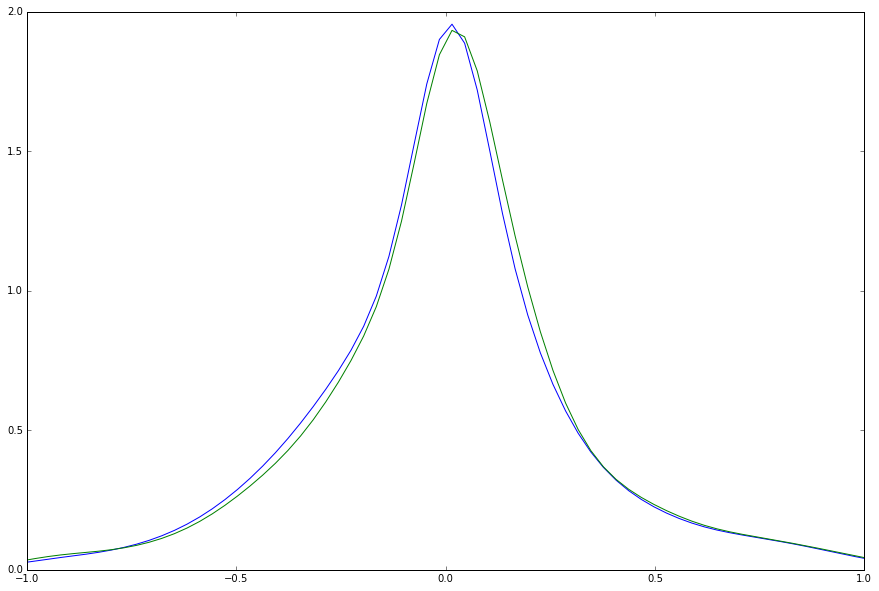

In [11]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1,1, figsize=(15,10))

density = gaussian_kde(data.Strokes_Gained.values)
xs = np.linspace(-3,3,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

density = gaussian_kde(data['Strokes_Gained/Baseline'].values)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))

plt.xlim(-1,1)

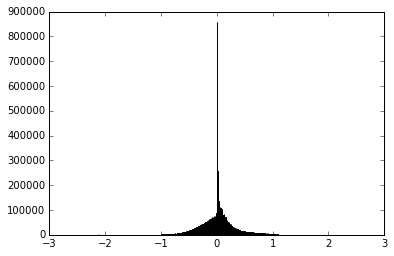

In [12]:
plt.hist(data.Strokes_Gained.values,bins=1000);

In [13]:
data.head()

,Year,Course_#,Round,Hole,Player_#,Strokes_Gained/Baseline,Hole_Score,Cat,Strokes_Gained,Difficulty_Start,Shots_taken_from_location,Shot
0,2004,35,1,1,1003,-0.119,5.0,Tee Box,-0.173873,4.818182,5.0,1
1,2004,35,1,1,1003,0.045,5.0,Primary Rough,0.173808,3.992054,4.0,2
2,2004,35,1,1,1003,0.026,5.0,Fairway,-0.001664,2.818247,3.0,3
3,2004,35,1,1,1003,-0.220,5.0,Green,-0.217774,1.819911,2.0,4
4,2004,35,1,1,1003,0.045,5.0,Green,0.037684,1.037684,1.0,5


In [14]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start)**2)**.5

0.49650290060787877

In [15]:
data.insert(len(data.columns),'Difficulty_Start_adam',[0]*len(data))
data.loc[data.Shot==data.Hole_Score,'Difficulty_Start_adam'] = data[data.Shot==data.Hole_Score].Strokes_Gained + 1
data=data.sort_values(['Year','Player_#','Course_#','Round','Hole'])
for i in range(1,int(data.Hole_Score.max())+1): ##i is hole_score
    for j in range(i-1,0,-1): ##j is shot
        data.loc[(data.Hole_Score==i) & (data.Shot==j),'Difficulty_Start_adam'] = \
                                data[(data.Hole_Score==i) & (data.Shot==j+1)].Difficulty_Start_adam.values +\
                                data[(data.Hole_Score==i) & (data.Shot==j)].Strokes_Gained.values + 1

In [16]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start_adam)**2)**.5

0.49650290060787877

In [17]:
#data = data.drop('Difficulty_Start_broadie',axis=1)
data.insert(len(data.columns),'Difficulty_Start_broadie',[0]*len(data))

In [18]:
data.loc[data.Shot==data.Hole_Score,'Difficulty_Start_broadie'] = data[data.Shot==data.Hole_Score]['Strokes_Gained/Baseline'] + 1

In [19]:
data=data.sort_values(['Year','Player_#','Course_#','Round','Hole'])
for i in range(1,int(data.Hole_Score.max())+1): ##i is hole_score
    for j in range(i-1,0,-1): ##j is shot
        data.loc[(data.Hole_Score==i) & (data.Shot==j),'Difficulty_Start_broadie'] = \
                                data[(data.Hole_Score==i) & (data.Shot==j+1)].Difficulty_Start_broadie.values +\
                                data[(data.Hole_Score==i) & (data.Shot==j)]['Strokes_Gained/Baseline'].values + 1

In [20]:
np.mean((data.Shots_taken_from_location-data.Difficulty_Start_broadie)**2)**.5

0.5024583995993779

Seeing if adding average of all data for tee difficulties in raw data helps. (It doesn't, strangely)

In [21]:
data.insert(len(data.columns),'New_Difficulty',data.Difficulty_Start)

In [22]:
import pickle
with open('./../PickleFiles/TeeDifficulty.pkl','r') as pickleFile:
    d = pickle.load(pickleFile)

In [23]:
years = [key[0] for key in d.keys()]
courses = [key[1] for key in d.keys()]
holes = [key[2] for key in d.keys()]
round = [key[3] for key in d.keys()]
difficulties = [d[key] for key in d.keys()]
df = pd.DataFrame({'Year':years,'Course_#':courses,'Hole':holes,'Round':round,'Tee_Difficulty':difficulties})

In [24]:
df.shape

(45702, 5)

In [25]:
df.head()

,Course_#,Hole,Round,Tee_Difficulty,Year
0,202,6,2,4.562500,2004
1,205,15,1,2.846154,2014
2,656,11,1,3.294118,2007
3,776,16,4,3.986301,2014
4,4,16,4,3.240506,2011


In [26]:
data = pd.merge(data, df, on=['Course_#','Hole','Round','Year'])

In [27]:
data.loc[data.Shot==1,'New_Difficulty'] = data.loc[data.Shot==1,'Tee_Difficulty']

In [28]:
np.mean((data.Shots_taken_from_location-data.New_Difficulty)**2)**.5

0.4977964286794666

In [29]:
data.New_Difficulty.describe()

count    1.235651e+07
mean     2.549828e+00
std      1.136031e+00
min      9.875988e-01
25%      1.552927e+00
50%      2.583656e+00
75%      3.373911e+00
max      5.518519e+00
Name: New_Difficulty, dtype: float64